In [ ]:
%reset -f

In [ ]:
!pip install equinox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import lax, vmap, jit
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import jax.lax as lax


import time
import optax

import pickle
from dataclasses import dataclass
from typing import Callable
import os

## Lutter contre le sur-apprentissage

### principe


Quand la courbe `train-losses` descent mais que cellte des `val-losses` remonte, on est en situation de sur-apprentissage.


Une solution très efficace pour limiter le sur-apprentissage dans les réseaux de neurones est le 'dropout'. Cela consiste à geler une partie aléatoire des neurones de certaines couches. Par exemple, supposons que l'on ai une couche de neurone `Y`. Faire l'opération:

    Z = Dropout(0.25)(Y)

signifie que l'on choisi un ensemble aléatoire d'indice $J$, dont la taille est de 25%  de la taille de $Y$,  et que l'on pose:
$$
 Z_j =
 \begin{cases}
  0 \text{ si } j \in J\\
  Y_j \text{ si } j \notin J
 \end{cases}
$$
La conséquence est que les gradients des paramètres conduisants à $J$ vont s'annuler, et donc ces paramètres ne seront pas impactés lors de la descente de gradient.  Détaillons cela sur un exemple très simple.

Commençons par décrire un début de modèle sans sans dropout:  il consiste en une série de transformation:
$$
X  \stackrel {W}  \longrightarrow Y \stackrel {h}  \longrightarrow E
$$
L'entrée est $X$. On fait ensuite une multiplication matricielle: $Y= XW$. Puis on fait toute sorte de transformation, puis on calcul l'erreur, et tout cela, on l'appelle $h$.






Intéressons nous au calcul de la dérivée de l'erreur $E$ suivant le coefficient $W_{ij}$. Puisque:
$$
Y_j = \sum_a X_a W_{aj}
$$
On a
$$
\frac{\partial Y_k}{\partial  W_{i j}} = X_{i} 1_{j=k}
$$
Et
$$
\frac{\partial E}{\partial W_{i j}} =\sum_k \frac{\partial E}{\partial Y_k}  \frac{\partial Y_k}{W_{i j}} = \frac{\partial E}{\partial Y_j}  \frac{\partial Y_j}{W_{i j}}
$$
En particulier quand vient la descente de gradient, la quantité ci-dessus est soustraite à $W_{ij}$.


Supposons maintenant que nous ajoutons un dropout:
$$
X  \stackrel {W}  \longrightarrow Y  \stackrel {dropout}  \longrightarrow   Z \stackrel {h}  \longrightarrow E
$$
La dérivée devient:
$$
\frac{\partial E}{\partial W_{i j}} = \frac{\partial E}{\partial Y_j}  \frac{\partial Y_j}{W_{i j}} 1_{j\notin J}
$$
Ainsi, pour tous les $j\in J$, la dérivée s'annule, et les poids correpondant $ W_{i j}$ resteront inchangées lors d'une itération de la descente de gradient.  


D'une itération à l'autre, les input-ouput changent, et l'ensemble $J$ change. Différentes parties du réseaux sont nouris avec différentes données.

Pour faire une analogie avec le cerveau humain: quand un enfant apprend à parler, il reçoit des tas d'informations orales, mais il est aussi en permance distrait par des stimuli variés (son hochet). Il apprend bien à parler mais sans rien apprendre par coeur.


### Compensation



En fait le dropout est légèrement plus compliqué que ce que nous avons expliqué précédemment:

Le dropout ne doit être effectuée que lors de la phase d'apprentissage: par la suite, quand on utilise le réseau bien entrainé, il serait dommage de laisser de côté 25% des neurones d'une couche.

Mais cela pose un problème: lors de l'entrainement,
quand on met à zéro 25% des neurones d'une couche, la quantité de signal à la sortie de la couche est en moyenne diminuée de 25%. C'est généant, car, en phase de test, le signal ne sera pas dimuné de 25%: il aura donc tendance à saturer les connections (n'oublions pas qu'il y a des fonctions d'activation après chaque couche).

Pour résoudre ce problème, l'opération

    Z = Dropout(q)(Y)

se traduit en fait par:
$$
 Z_j =
 \begin{cases}
  0 \text{ si } j \in J\\
  \frac 1 {1-q} Y_j \text{ si } j \notin J
 \end{cases}
$$
Par exemple si $q=0.75$, à la sortie, les parties non mises à zéro seront multiplées par 4 pour que le signal conserve son "amplitude".

***Remarque:*** On aurait peu aussi diminuer le signal durant la phase test. Mais c'est une moins bonne idée, car on souhaite que le réseau soit le plus rapide possible durant la phase d'exploitation (=la phase "test").


### En pratique

In [ ]:
droupout_module=eqx.nn.Dropout(p=0.5,inference=False)

In [ ]:
for k in jr.split(jr.key(0),4):
    print(droupout_module(jnp.ones([10]),key=k))

Inférence (=prédiction). Le dropout est désactivé.

In [ ]:
droupout_module_for_inference=eqx.tree_inference(droupout_module,True)
for k in jr.split(jr.key(0),4):
    print(droupout_module_for_inference(jnp.ones([10]),key=k))

### Observons le code equinox

Voici une implémentation à la maindu Dropout. Une légère simplification du code equinox.

In [ ]:
from jaxtyping import Array, PRNGKeyArray


class Dropout(eqx.Module):
    p: float
    inference: bool

    def __init__(
        self,
        p: float = 0.5,
        inference: bool = False
    ):
        """
        - `p`: The fraction of entries to set to zero. (On average.)
        - `inference`: Whether to actually apply dropout at all. If `True` then dropout
            is *not* applied. If `False` then dropout is applied. This may be toggled
            with `equinox.nn.inference_mode`
        """
        self.p = p
        self.inference = inference

    def __call__(
        self,
        x: Array,
        *,
        key: PRNGKeyArray | None = None,
    ) -> Array:
        """
        - `x`: An any-dimensional JAX array to dropout.
        - `key`: A `jax.random.PRNGKey` used to provide randomness for calculating
            which elements to dropout. (Keyword only argument.)
        """

        if self.inference:
            return x

        q = 1 - lax.stop_gradient(self.p)
        mask = jr.bernoulli(key, q, x.shape)
        return jnp.where(mask, x / q, 0)

`lax.stop_gradient` évide que la rétropopagation passe par le paramètre `p`. Cela fait gagner un peu de temps, mais surtout, cela évide que `p` soit modifié si un utilisateur filtre de la mauvaise manière un modèle. Ce ne sera pas notre cas, voir plus bas.   

###  Le dropout dans un modèle

In [ ]:
class MyModel(eqx.Module):
    linear: eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, dim_in, dim_out, key):
        k1, k2 = jr.split(key)
        self.linear = eqx.nn.Linear(dim_in, dim_out, key=k1)
        self.dropout = eqx.nn.Dropout(p=0.5)


    #habituellement on utilise '__call__', mais on peut choisir ce qu'on veut
    def apply(self, x, key=None): # random-key requis pour l'entraînement, pas pour l'inférence
        x = self.linear(x)
        x = self.dropout(x, key=key)
        return x



def model_init_apply_fnm(dim_in,dim_out):

    def model_init(rkey):
        model=MyModel(dim_in,dim_out,rkey)
        param,static=eqx.partition(model, eqx.is_array)
        return param

    model_train=MyModel(dim_in,dim_out,jr.key(0))
    @jax.jit
    def model_apply_train(param,inp,rkey):
        _,static=eqx.partition(model_train, eqx.is_array)
        return eqx.combine(param,static).apply(inp,rkey)


    model_inference=MyModel(dim_in,dim_out,jr.key(0))
    model_interence=eqx.tree_inference(model_inference, True)
    @jax.jit
    def model_apply_inference(param,inp):
        _,static=eqx.partition(model_inference, eqx.is_array)
        return eqx.combine(param,static).apply(inp)


    return model_init,model_apply_train,model_apply_inference


dim_in,dim_out=3,10

model_init,model_apply_train,model_apply_inference=model_init_apply_fnm(dim_in,dim_out)


⇑ Que fait `eqx.tree_inference(model, True)` ?

Elle traverse récursivement l'arbre de `model`.
Pour chaque module Equinox rencontré, elle définit l'attribut interne `inference` à True.

Une variante perso ou je fais apparaitre plus explicitement l'attribut décidant du mode 'inference' ou 'train'. Attention, il faudrait aussi adapter le model_fnm. Mais cette variante est déconseillée: la bonne pratique c'est de laisser equinox gérer.

In [ ]:
#Variante perso
class MyModel2(eqx.Module):
    linear: eqx.nn.Linear
    dropout: eqx.nn.Dropout
    for_inference:bool

    def __init__(self, dim_in, dim_out, key,for_inference):
        self.for_inference=for_inference
        k1, k2 = jr.split(key)
        self.linear = eqx.nn.Linear(dim_in, dim_out, key=k1)
        self.dropout = eqx.nn.Dropout(p=0.5)

    def apply(self, x, key=None): # random-key requis pour l'entraînement, pas pour l'inférence
        x = self.linear(x)
        if self.for_inference:
            return x
        else:
            return self.dropout(x, key=key)

In [ ]:
param=model_init(jr.key(42))
eqx.tree_pprint(param)

***A vous:*** Est-ce que la proba du dropout apparait dans les quantité à entrainer ?

In [ ]:
inp = jnp.ones([dim_in])

In [ ]:
out_train = model_apply_train(param, inp, jr.key(67))  # dropout actif → valeurs masquées
out_train

In [ ]:
out_inference = model_apply_inference(param, inp)  # dropout actif → valeurs masquées
out_inference

In [ ]:
out_train/2

***A vous:*** Pourquoi retrouve-t-on des coefficients identiques entre `out_inference` et `out_train/2` ?

### Pour un batch de donnée

Il faut faire attention: chaque élément d'un batch doit être masqué différemment de son voisin.

In [ ]:
model_apply_train_V=jax.vmap(model_apply_train,[None,0,0])

In [ ]:
batch_size=7
inpV=jnp.ones([batch_size,dim_in])
#multiplions les keys:
keyV=jr.split(jr.key(0),batch_size)
keyV.shape

In [ ]:
model_apply_train_V(param,inpV,keyV)

## En 2D



## Défit prog: 2d spacial dropout

### Utilisons notre ré-implémentation

In [ ]:
droupout_module=Dropout(p=0.5,inference=False)

In [ ]:
for k in jr.split(jr.key(0),4):
    print(droupout_module(jnp.ones([10]),key=k))

In [ ]:
droupout_module_for_inference=eqx.tree_inference(droupout_module,True)
for k in jr.split(jr.key(0),4):
    print(droupout_module_for_inference(jnp.ones([10]),key=k))

### Utilisons là en 2d

In [ ]:
"fonctions utilitaires"
def plot_images(images,vmin=None,vmax=None):

    batch_size,n_channel,_,_=images.shape


    fig,axs=plt.subplots(batch_size,n_channel,figsize=(2*n_channel,2*batch_size))
    axs=axs.reshape([batch_size,n_channel])#au cas une des quantité vaut 1

    vmin=jnp.min(images) if vmin is None else vmin
    vmax=jnp.max(images) if vmax is None else vmax

    for i in range(batch_size):
        for j in range(n_channel):
            axs[i,j].imshow(images[i,j,:,:], interpolation="nearest",vmin=vmin,vmax=vmax)
            if j==0:
                axs[i,j].set_ylabel(f"{i}-ième image")
            if i==0:
                axs[i,j].set_title(f"{j}-ième channel")
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    fig.tight_layout()

In [ ]:
dropout_fn=lambda inp,key:eqx.nn.Dropout(0.7)(inp,key=key)
dropout_fn_V=jax.vmap(dropout_fn)

In [ ]:
inpV = jnp.ones((batch_size,6, 10, 10))
rkeyV = jr.split(jr.key(0),batch_size)
outV= dropout_fn_V(inpV,rkeyV)
outV.shape

In [ ]:
plot_images(outV,0,1)

### Mais c'est du spacial-dropout qu'il  faut pour des images

Les pixels d'un même channel d'une image sont très correlé. En masquer une partie n'a pas beaucoup d'effet.

Le spatial dropout consiste à masquer des channels complet (observer le plot plus bas). Et c'est ça qui marche pour éviter le sur-apprentissage.


In [ ]:
from jaxtyping import Array, PRNGKeyArray


class SpaticalDropout2D(eqx.Module):
    p: float
    inference: bool

    def __init__(
        self,
        p: float = 0.5,
        inference: bool = False
    ):
        """
        - `p`: The fraction of entries to set to zero. (On average.)
        - `inference`: Whether to actually apply dropout at all. If `True` then dropout
            is *not* applied. If `False` then dropout is applied. This may be toggled
            with `equinox.nn.inference_mode`
        """
        self.p = p
        self.inference = inference


    def __call__(
        self,
        x: Array,
        *,
        key: PRNGKeyArray | None = None,
    ) -> Array:

        assert  len(x.shape)==3
        """
        - `x`: An 3-dimensional JAX array to dropout. dimension are (n_channel,img_height, imp_width)
        - `key`: A `jax.random.PRNGKey` used to provide randomness for calculating which elements to dropout. (Keyword only argument.)
        """
        n_channel,img_height, imp_width=x.shape

        if self.inference:
            return x

        FINISSEZ LE PROGRAMME


In [ ]:
dropout_fn=lambda inp,key:SpaticalDropout2D(0.5)(inp,key=key)
dropout_fn_V=jax.vmap(dropout_fn)

In [ ]:
inpV = jnp.ones((batch_size,6, 10, 10))
rkeyV = jr.split(jr.key(0),batch_size)
outV= dropout_fn_V(inpV,rkeyV)
outV.shape

In [ ]:
#--- To keep following outputs, do not run this cell! ---

(7, 6, 10, 10)

In [ ]:
plot_images(outV,0,1)

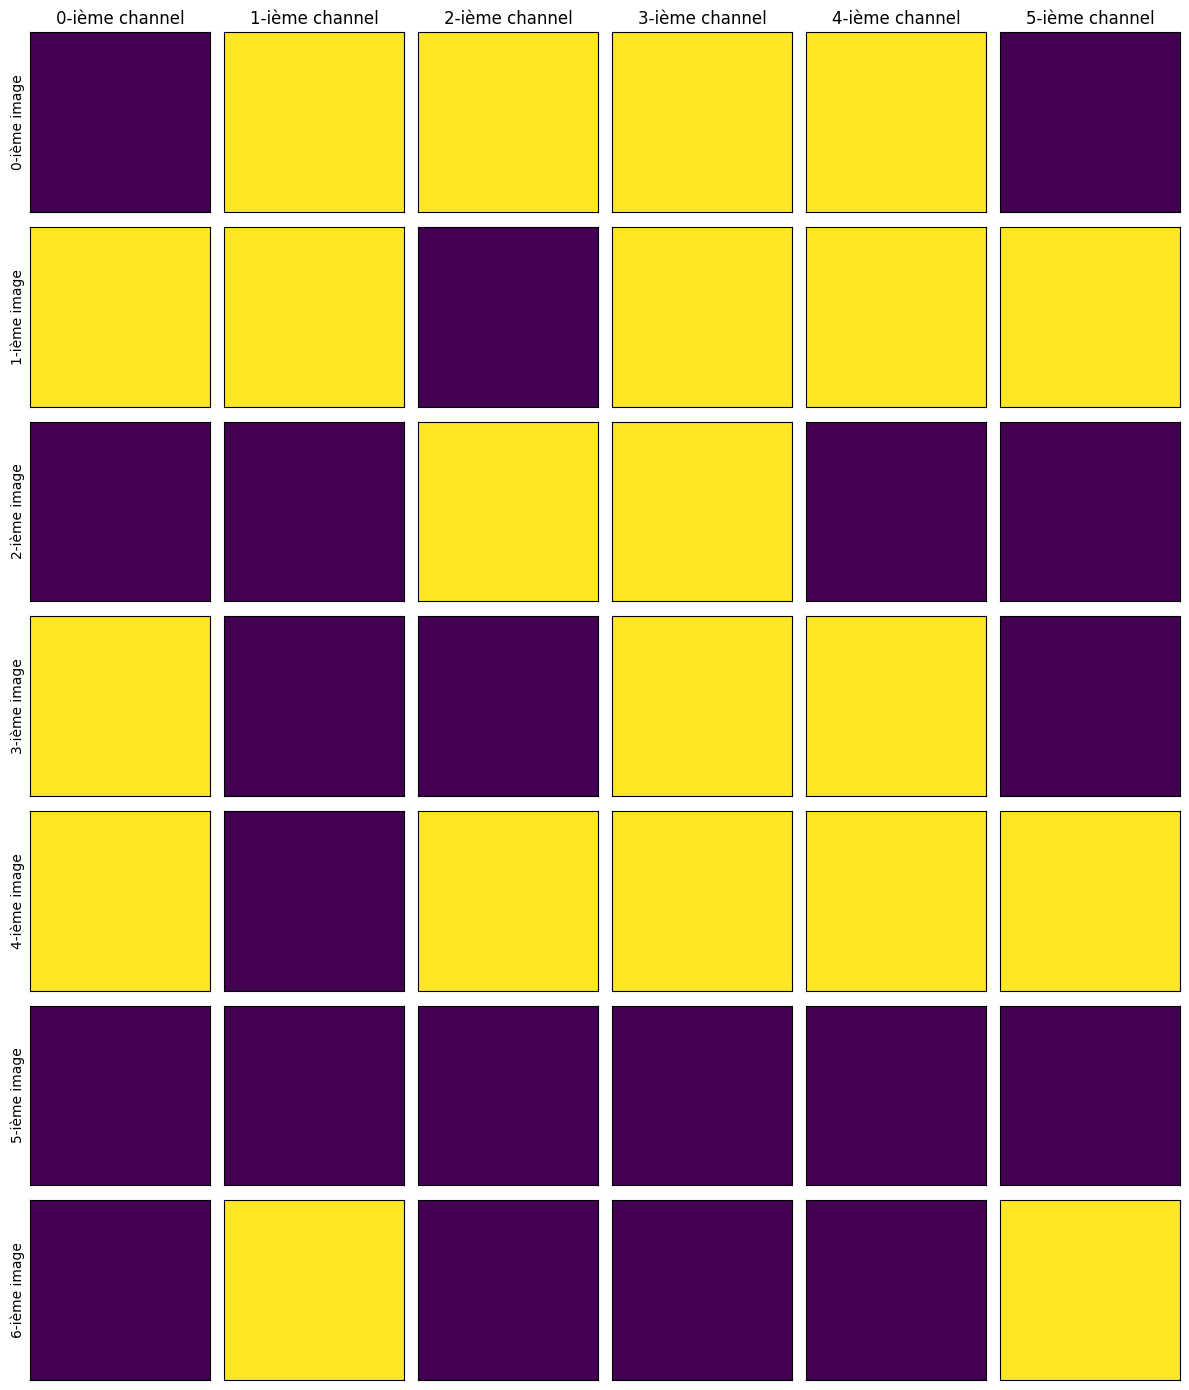

In [ ]:
#--- To keep following outputs, do not run this cell! ---